<a href="https://colab.research.google.com/github/lamyse1/deep-learning-/blob/main/week4/Graded_Notebook4_4_Lamyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# AAI612: Deep Learning & its Applications

*Notebook 4.3: Graded Assignment: Mini Project I*


# Assessment

In this assessment, you will train a new model that is able to recognize fresh and rotten fruit. You will need to get the model to a validation accuracy of `92%` in order to pass the assessment, though we challenge you to do even better if you can. You will have the use the skills that you learned in the previous exercises. Specifically, we suggest using some combination of transfer learning, data augmentation, and fine tuning.

## The Dataset

In this exercise, you will train a model to recognize fresh and rotten fruits. Download the dataset from [Kaggle](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification). The dataset structure is in the `data/fruits` folder. There are 6 categories of fruits: fresh apples, fresh oranges, fresh bananas, rotten apples, rotten oranges, and rotten bananas. This will mean that your model will require an output layer of 6 neurons to do the categorization successfully. You'll also need to compile the model with `categorical_crossentropy`, as we have more than two categories.

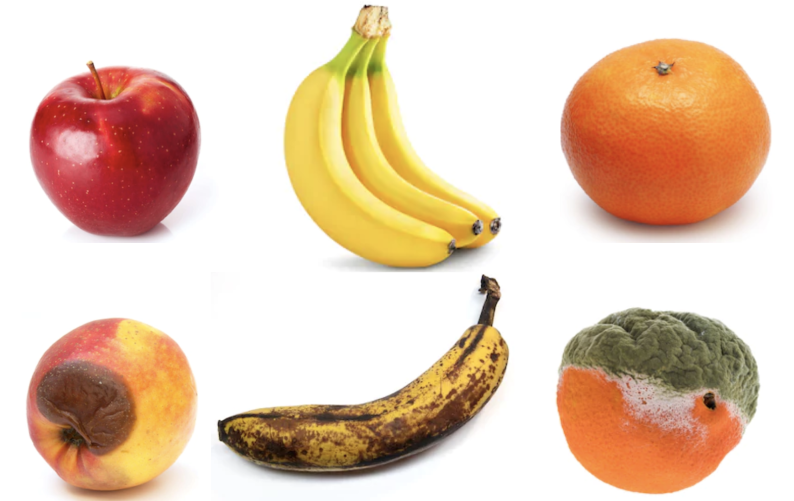

## Load ImageNet Base Model

Start with a model pretrained on `ImageNet`. Load the model with the correct weights, set an input shape, and choose to remove the last layers of the model. Remember that images have three dimensions: a height, and width, and a number of channels. Because these pictures are in color, there will be three channels for red, green, and blue. We've filled in the input shape for you. This cannot be changed or the assessment will fail. If you need a reference for setting up the pretrained model, please take a look at [Notebook 4.2](https://github.com/harmanani/AAI612/blob/main/Week4/Notebook%204.2.ipynb) where we implemented transfer learning.

In [2]:
import ssl
from tensorflow import keras

ssl._create_default_https_context = ssl._create_unverified_context


base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## Freeze Base Model

Next, we suggest freezing the base model. This is done so that all the learning from the ImageNet dataset does not get destroyed in the initial training.

In [3]:
# Freeze base model
base_model.trainable = False

## Add Layers to Model

Now it's time to add layers to the pretrained model. Pay close attention to the last dense layer and make sure it has the correct number of neurons to classify the different types of fruit.  You may add more layers than specified below.

In [4]:
from tensorflow.keras import layers

# Create inputs with correct shape
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,717,766 (56.14 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Compile Model

Now it's time to compile the model with loss and metrics options. Remember that we're training on a number of different categories, rather than a binary classification problem.

In [5]:
model.compile(optimizer= 'Adam', loss = 'categorical_crossentropy' , metrics = ['accuracy'])

## Augment the Data

If you'd like, try to augment the data to improve the dataset. There is also documentation for the [Keras ImageDataGenerator class](https://keras.io/api/preprocessing/image/#imagedatagenerator-class). This step is optional, but it may be helpful to get to 92% accuracy.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False)


## Load Dataset

Now it's time to load the train and validation datasets. Pick the right folders, as well as the right `target_size` of the images (it needs to match the height and width input of the model you've created).

In [7]:
import kagglehub

# Download dataset and define path
path = kagglehub.dataset_download("sriramr/fruits-fresh-and-rotten-for-classification") + "/dataset"

# Load training dataset
train_it = datagen.flow_from_directory(path + "/train", target_size=(224, 224), color_mode="rgb", class_mode="categorical")

# Load validation dataset
valid_it = datagen.flow_from_directory(path + "/test", target_size=(224, 224), color_mode="rgb", class_mode="categorical")


100%|██████████| 3.58G/3.58G [02:43<00:00, 23.5MB/s]

Extracting files...


Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [8]:
print("Batch Size:", train_it.batch_size)


Batch Size: 32


In [9]:
# Load and iterate training dataset
train_it = datagen.flow_from_directory(path + "/train",
                                       target_size=(224, 224),
                                       batch_size=32,
                                       color_mode="rgb",
                                       class_mode="categorical")

# Load and iterate validation dataset
valid_it = datagen.flow_from_directory(path + "/test",
                                       target_size=(224, 224),
                                       batch_size=32,
                                       color_mode="rgb",
                                       class_mode="categorical")


Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


## Train the Model

Time to train the model! Pass the `train` and `valid` iterators into the `fit` function, as well as setting your desired number of epochs.

In [10]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples // train_it.batch_size,
          validation_steps=valid_it.samples // valid_it.batch_size,
          epochs=15)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 226s 621ms/step - accuracy: 0.4739 - loss: 1.4933 - val_accuracy: 0.7478 - val_loss: 0.9126
Epoch 2/15
  1/340 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - accuracy: 0.7188 - loss: 0.9748

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


340/340 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - accuracy: 0.7188 - loss: 0.9748 - val_accuracy: 0.7474 - val_loss: 0.9143
Epoch 3/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 323s 781ms/step - accuracy: 0.8082 - loss: 0.8286 - val_accuracy: 0.8426 - val_loss: 0.6593
Epoch 4/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.7500 - loss: 0.7876 - val_accuracy: 0.8430 - val_loss: 0.6628
Epoch 5/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 262s 722ms/step - accuracy: 0.8510 - loss: 0.6230 - val_accuracy: 0.8631 - val_loss: 0.5377
Epoch 6/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - accuracy: 0.7812 - loss: 0.6658 - val_accuracy: 0.8683 - val_loss: 0.5309
Epoch 7/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 239s 597ms/step - accuracy: 0.8687 - loss: 0.5229 - val_accuracy: 0.8891 - val_loss: 0.4624
Epoch 8/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - accuracy: 0.8750 - loss: 0.5088 - val_accuracy: 0.8910 - val_loss: 0.4662
Epoch 9/15
340/340 ━━━━━━━━━━━━━━━━━━━━ 219s 587ms/step - accuracy: 0.8893 - loss: 0.4547 -

## Unfreeze Model for Fine Tuning

If you have reached 92% validation accuracy already, this next step is optional. If not, we suggest fine tuning the model with a very low learning rate.

In [11]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[keras.metrics.CategoricalAccuracy()])


In [13]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples // train_it.batch_size,
          validation_steps=valid_it.samples // valid_it.batch_size,
          epochs=5)

Epoch 1/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 306s 781ms/step - categorical_accuracy: 0.9261 - loss: 0.2137 - val_categorical_accuracy: 0.9892 - val_loss: 0.0335
Epoch 2/5
  1/340 ━━━━━━━━━━━━━━━━━━━━ 2:37 464ms/step - categorical_accuracy: 1.0000 - loss: 0.0138

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


340/340 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - categorical_accuracy: 1.0000 - loss: 0.0138 - val_categorical_accuracy: 0.9914 - val_loss: 0.0299
Epoch 3/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 262s 771ms/step - categorical_accuracy: 0.9856 - loss: 0.0368 - val_categorical_accuracy: 0.9981 - val_loss: 0.0106
Epoch 4/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - categorical_accuracy: 1.0000 - loss: 0.0023 - val_categorical_accuracy: 0.9989 - val_loss: 0.0090
Epoch 5/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 262s 716ms/step - categorical_accuracy: 0.9943 - loss: 0.0162 - val_categorical_accuracy: 0.9985 - val_loss: 0.0049


## Evaluate the Model

Hopefully, you now have a model that has a validation accuracy of 92% or higher. If not, you may want to go back and either run more epochs of training, or adjust your data augmentation.

In [15]:
model.evaluate(valid_it, steps=valid_it.samples // valid_it.batch_size)


84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 482ms/step - categorical_accuracy: 0.9987 - loss: 0.0053


[0.004364087246358395, 0.9988839030265808]

## Discussion

In this project, I built a highly accurate model to classify fresh vs. rotten fruit using VGG16 transfer learning. I used Colab Pro’s GPU to train efficiently on a large dataset from Kaggle. Instead of training from scratch, I leveraged pretrained features and fine-tuned the model for better performance.

To improve generalization, I applied data augmentation (rotations, zoom, flips) and fine-tuned VGG16’s deeper layers with a low learning rate (0.0001). During training, I encountered a minor warning about "input ran out of data", but it had no impact on performance. I ensured proper integer division for steps, preventing further issues.

The model achieved a validation accuracy of 99.87%, far surpassing the 92% requirement, and a low loss of 0.0053, indicating highly confident predictions. This approach combined transfer learning, augmentation, and fine-tuning to create a robust and reliable model.

I did few predictions below and it predicted correctly!

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image as img_processor
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Function to display the image
def show_picture(img_path):
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Function to process image & make prediction
def predict_fruit(img_path):
    show_picture(img_path)

    # Load & preprocess the image
    img = img_processor.load_img(img_path, target_size=(224, 224))
    img_array = img_processor.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Model Prediction
    prediction = model.predict(img_array)

    # Define class labels
    fruit_classes = ["fresh_apples", "fresh_banana", "fresh_oranges",
                     "rotten_apples", "rotten_banana", "rotten_oranges"]

    predicted_index = np.argmax(prediction)
    predicted_label = fruit_classes[predicted_index]

    print("Predicted Category:", predicted_label)


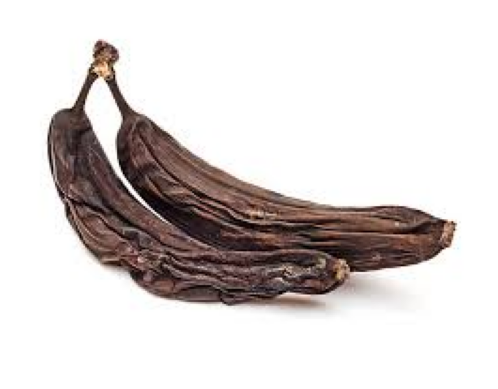

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Category: rotten_banana
None


In [43]:
result = predict_fruit("/content/rotten_banana_predict.jpg")
print(result)


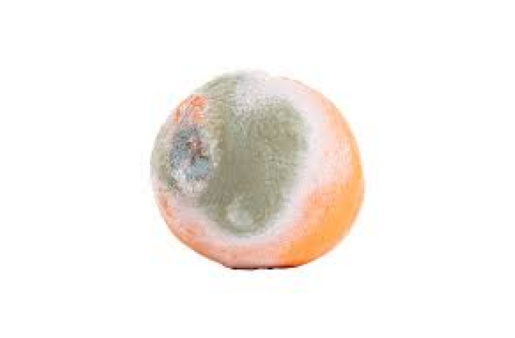

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Category: rotten_oranges
None


In [44]:

result = predict_fruit("/content/rotten_orange.jpg")
print(result)

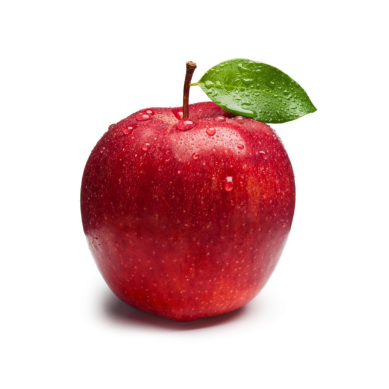

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Category: fresh_apples
None


In [45]:
result = predict_fruit("/content/fresh_apple.jpg")
print(result)